# Programming Exercise 8: Anomaly Detection

## Introduction

In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies. Before starting on the programming exercise, we strongly recommend watching the video lectures and completing the review questions for the associated topics. The files included in this assignment are: 

- ex8data1.mat - First example Dataset for anomaly detection 
- ex8data2.mat - Second example Dataset for anomaly detection
- multivariateGaussian.m - Computes the probability density function for a Gaussian distribution
- visualizeFit.m - 2D plot of a Gaussian distribution and a dataset

You only have to implement these two functions:

- estimateGaussian.m - Estimate the parameters of a Gaussian distribution with a diagonal covariance matrix
- selectThreshold.m - Find a threshold for anomaly detection

The contained files are found in File --> Open... We highly recommend that you take a look at them as you make progress in this exercise. 

### NOTE:

You will find cells which contain the comment % GRADED FUNCTION: functionName. Do not edit that comment. Those cells will be used to grade your assignment. Each block of code with that comment should only have the function. 

Instructions will be provided as needed in the exercise. 


#### When you are done and submit the assignment, click here to check your [submission](https://www.coursera.org/learn/machine-learning/programming/As4wv/anomaly-detection). 



Anomaly detection
=================

In this exercise, you will implement an anomaly detection algorithm to
detect anomalous behavior in server computers. The features measure the
throughput (mb/s) and latency (ms) of response of each server. While
your servers were operating, you collected $m=307$ examples of how they
were behaving, and thus have an unlabeled dataset
$\{x^{(1)}, \ldots, x^{(m)}\}$. You suspect that the vast majority of
these examples are “normal” (non-anomalous) examples of the servers
operating normally, but there might also be some examples of servers
acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your
dataset. You will first start on a 2D dataset that will allow you to
visualize what the algorithm is doing. On that dataset you will fit a
Gaussian distribution and then find values that have very low
probability and hence can be considered anomalies. After that, you will
apply the anomaly detection algorithm to a larger dataset with many
dimensions. 

In the first part we will visualize the dataset as shown in
Figure 1.

<img src="../../readonly/Assignment8a/figure 1.png" width="500" height="500">

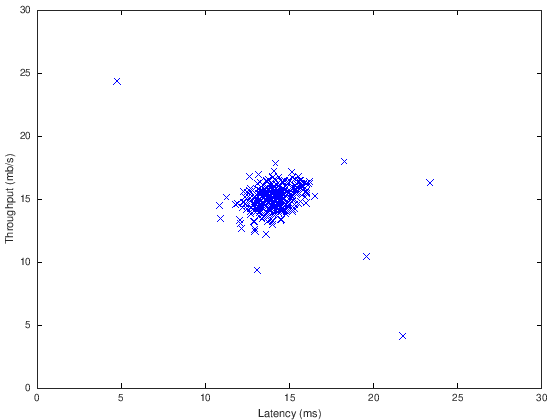

In [15]:
warning('off'); addpath('../../readonly/Assignment8a');
load('ex8data1.mat');                    % You should now have X and y in your environment
plot(X(:, 1), X(:, 2), 'bx');            % Visualize the example dataset
axis([0 30 0 30]);
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');

Gaussian distribution
---------------------

To perform anomaly detection, you will first need to fit a model to the
data’s distribution.

Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ (where $x^{(i)} \in
\mathbb{R}^n$), you want to estimate the Gaussian distribution for each
of the features $x_i$. For each feature $i = 1\ldots n$, you need to find
parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th
dimension $\{x_i^{(1)}, ...,
x_i^{(m)}\}$ (the $i$-th dimension of each example).

The Gaussian distribution is given by

$$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

Estimating parameters for a Gaussian
------------------------------------

You can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th
feature by using the following equations. To estimate the mean, you will
use:

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

Your task is to complete the code in *estimateGaussian*. This
function takes as input the data matrix $X$ and should output an
$n$-dimension vector $\mu$ that holds the mean of all the $n$
features and another $n$-dimension vector **sigma 2** that holds the
variances of all the features. You can implement this using a for-loop
over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). Note that in Octave/MATLAB, the var
function will (by default) use $\frac{1}{m-1}$, instead of $\frac{1}{m}$ , when computing $\sigma_i^2$.

**Implementation**: 

[mu sigma2] = **estimateGaussian(X)**  The input X is the dataset with each n-dimensional data point in one row The output is an n-dimensional vector mu, the mean of the data set and the variances $\sigma^2$, an n x 1 vector. You should compute the mean of the data and the variances.
              In particular, mu(i) should contain the mean of
              the data for the i-th feature and sigma2(i)
              should contain variance of the i-th feature.

In [18]:
% GRADED FUNCTION: estimateGaussian
function [mu sigma2] = estimateGaussian(X)

[m, n] = size(X);           % Useful variables
mu = zeros(n, 1);           % Return these values correctly
sigma2 = zeros(n, 1);

% ====================== YOUR CODE HERE ======================
mu = mean(X);
sigma2 = (sum((X-mu).^2))/m; % octave fnc use m -1

% ============================================================
end

Now that you have completed the code in estimateGaussian, we will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to Figure 2. From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

<img src="../../readonly/Assignment8a/figure 2.png" width="500" height="500">
 
Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine. This exercise will help us find possibly faulty (or very fast) machines.

For this exercise, we assume a Gaussian distribution for the dataset. We first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.



mu =

   14.112   14.998

sigma2 =

   1.8326   1.7097



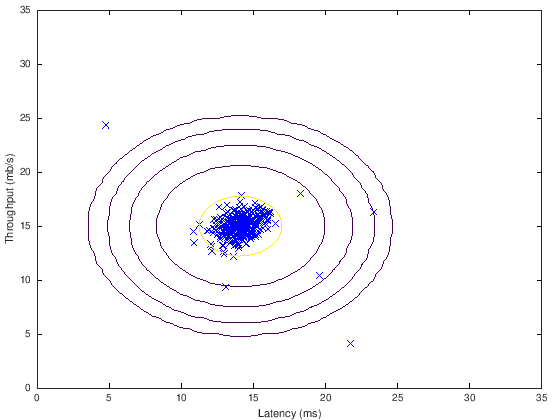

In [19]:
[mu sigma2] = estimateGaussian(X);                  %  Estimate my and sigma2


p = multivariateGaussian(X, mu, sigma2);     %  Returns the density of the multivariate normal 
                                             %  at each data point (row) of X

visualizeFit(X,  mu, sigma2);                %  Visualize the fit
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');
mu
sigma2

**Expected Output**: 

mu : [14.112   14.998]

sigma: [1.8326 1.7097]


Selecting the threshold, $\varepsilon$
--------------------------------------

Now that you have estimated the Gaussian parameters, you can investigate
which examples have a very high probability given this distribution and
which examples have a very low probability. The low probability examples
are more likely to be the anomalies in our dataset. One way to determine
which examples are anomalies is to select a threshold based on a cross
validation set. In this part of the exercise, you will implement an
algorithm to select the threshold $\varepsilon$ using the $F_1$ score on
a cross validation set.

You should now complete the code in *selectThreshold*. For this,
we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$,
where the label $y=1$ corresponds to an anomalous example, and $y=0$
corresponds to a normal example. For each cross validation example, we
will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these
probabilities
$p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv)}})$ is passed to
*selectThreshold* in the vector *pval*. The corresponding
labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv)}}$ is passed
to the same function in the vector *yval*.

The function *selectThreshold* should return two values; the
first is the selected threshold $\varepsilon$. If an example $x$ has a
low probability $p(x) <
\varepsilon$, then it is considered to be an anomaly. The function
should also return the $F_1$ score, which tells you how well you’re
doing on finding the ground truth anomalies given a certain threshold.
For many different values of $\varepsilon$, you will compute the
resulting $F_1$ score by computing how many examples the current
threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):
$$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec},
$$ You compute precision and recall by: $$\begin{aligned}
    prec&=&\frac{tp}{tp+fp}\\
    rec&=&\frac{tp}{tp+fn},
\end{aligned}$$ where

-   $tp$ is the number of true positives: the ground truth label says
    it’s an anomaly and our algorithm correctly classified it as an
    anomaly.

-   $fp$ is the number of false positives: the ground truth label says
    it’s not an anomaly, but our algorithm incorrectly classified it as
    an anomaly.

-   $fn$ is the number of false negatives: the ground truth label says
    it’s an anomaly, but our algorithm incorrectly classified it as not
    being anomalous.

In the provided code *selectThreshold*, there is already a loop
that will try many different values of $\varepsilon$ and select the best
$\varepsilon$ based on the $F_1$ score.

You should now complete the code in *selectThreshold*. You can
implement the computation of the *F1* score using a for-loop over
all the cross validation examples (to compute the values $tp, fp, fn$). You should see a
value for epsilon of about 8.99e-05.

<img src="../../readonly/Assignment8a/figure 3.png" width="500" height="500">


<table border = "0" width = "600"><tr><td> 

**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may
be able to use a vectorized implementation rather than loop over all the examples.
This can be implemented by Octave/MATLAB's equality test between a vector
and a single number.  If you have several binary values in an $n$-dimensional
binary vector $v\in \{0,1\}^n $, you can find out how many values in this vector
are 0 by using:  *sum($v$ == 0)*. You can also apply a logical *and* operator
to such binary vectors. For instance, let  *cvPredictions* be a binary
vector of the size of your number of cross validation set, where the $i$-th
element is 1 if your algorithm considers $x_{\rm cv}^{(i)}$ an anomaly, and 0
otherwise.  You can then, for example, compute the number of false positives using:  fp =
sum((cvPredictions == 1) & (yval == 0)).

</td></tr></table>


[bestEpsilon bestF1] = selectThreshold(yval, pval) finds the best threshold to use for selecting outliers based on the results from a validation set (pval) and the ground truth (yval). You should compute the F1 score of choosing epsilon as the
              threshold and place the value in F1. The code at the
              end of the loop will compare the F1 score for this
              choice of epsilon and set it to be the best epsilon if
              it is better than the current choice of epsilon.
              


In [20]:
% GRADED FUNCTION: selectThreshold
function [bestEpsilon bestF1] = selectThreshold(yval, pval)

bestEpsilon = 0;
bestF1 = 0;
F1 = 0;

stepsize = (max(pval) - min(pval)) / 1000;
for epsilon = min(pval):stepsize:max(pval)
    
    % ====================== YOUR CODE HERE ======================
    precision = 0; recall = 0; F1 = 0;

    predicted = pval < epsilon;
    fp = sum(predicted > yval);
    tp = sum(yval + predicted == 2);
    fn = sum(yval > predicted);
    tn = sum(yval + predicted == 0);

    if (tp + fp != 0)
        precision = tp/(tp + fp);
        recall = tp/(tp + fn);
    end
    if (precision + recall !=0)
        F1 = 2 * (precision * recall) / (precision + recall);
    end
    % =============================================================

    if F1 > bestF1
       bestF1 = F1;
       bestEpsilon = epsilon;
    end
end
end

Now we will run your anomaly detection code and circle the anomalies in the plot (Figure 3). The code below will find a good epsilon threshold using a cross-validation set of probabilities given the estimated Gaussian distribution.

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)



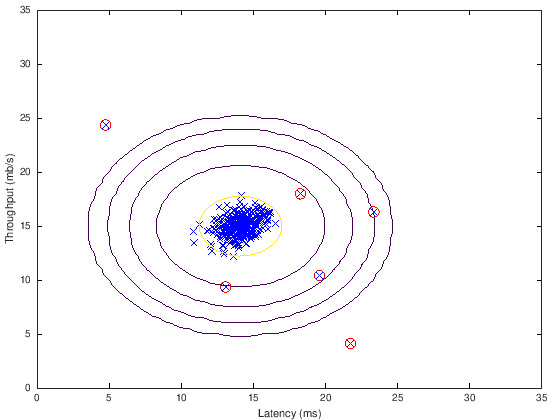

In [21]:
pval = multivariateGaussian(Xval, mu, sigma2);                 

[epsilon F1] = selectThreshold(yval, pval);
fprintf('Best epsilon found using cross-validation: %e\n', epsilon);
fprintf('Best F1 on Cross Validation Set:  %f\n', F1);
fprintf('   (you should see a value epsilon of about 8.99e-05)\n\n');

outliers = find(p < epsilon);                %  Find the outliers in the training set and plot the


visualizeFit(X,  mu, sigma2);                %  Visualize the fit
xlabel('Latency (ms)');
ylabel('Throughput (mb/s)');
hold on                                      %  Draw a red circle around those outliers
plot(X(outliers, 1), X(outliers, 2), 'ro', 'LineWidth', 2, 'MarkerSize', 10);
hold off

High dimensional dataset
------------------------

Now we will run the anomaly detection
algorithm you implemented on a more realistic and much harder dataset.
In this dataset, each example is described by 11 features, capturing
many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters
($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the
training data $X$ from which you estimated the Gaussian parameters,
and do so for the the cross-validation set $Xval$. Finally, it will
use *selectThreshold* to find the best threshold $\varepsilon$. You
should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [22]:
%  Loads the second dataset. You should now have the
%  variables X, Xval, yval in your environment
load('ex8data2.mat');


[mu sigma2] = estimateGaussian(X);                %  Apply the same steps to the larger dataset

p = multivariateGaussian(X, mu, sigma2);          %  Training set 

pval = multivariateGaussian(Xval, mu, sigma2);    %  Cross-validation set

[epsilon F1] = selectThreshold(yval, pval);       %  Find the best threshold


fprintf('Best epsilon found using cross-validation: %e\n', epsilon);
fprintf('Best F1 on Cross Validation Set:  %f\n', F1);
fprintf('# Outliers found: %d\n', sum(p < epsilon));
fprintf('   (you should see a value epsilon of about 1.38e-18)\n\n');


Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Outliers found: 117
   (you should see a value epsilon of about 1.38e-18)



**Expected Output**

Best epsilon found using cross-validation: 1.377229e-18

Best F1 on Cross Validation Set:  0.615385

Outliers found: 117